**Sprint 3: Model Development**

In [116]:
#Dependencies
%pip install optuna
%pip install xgboost
%pip install eli5
import os
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
from optuna import create_study
from optuna.pruners import MedianPruner
from optuna.visualization import plot_optimization_history, plot_param_importances
import optuna
import eli5
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


**Load the data**

In [117]:
# Load compressed datasets from .npz files
X_test_base = sparse.load_npz("../data/X_test_baseline.npz")
X_train_base = sparse.load_npz("../data/X_train_baseline.npz")
X_test = sparse.load_npz("../data/X_test_engineered.npz")
X_train = sparse.load_npz("../data/X_train_engineered.npz")
y_train = np.load("../data/y_train.npy")
X_test = sparse.csr_matrix(X_test)
X_train = sparse.csr_matrix(X_train)

Split the training data into 2 sets: training and validation. We use TimeSeriesSplit for time-aware cross-validation. TimeSeriesSplit returns the first k folds as the train set, while using the k+1-th set as the valid set. This allows the model to be validated against future observations least like those that are used to train the model.

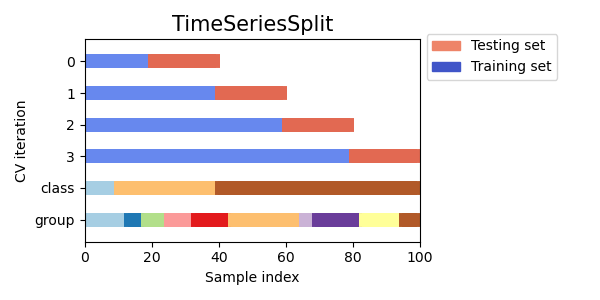

(Note that the index is sorted by time)

In [118]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X_train))
train_idx, valid_idx = splits[-1]
X_tr, X_val = X_train_base[train_idx], X_train_base[valid_idx]
y_tr, y_val = y_train[train_idx], y_train[valid_idx]

We propose a list of potential classifiers. I only chose 5, because of hardware constraints.

In [119]:
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=5000)),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("XGBoost", XGBClassifier())
]

For each classifier:
- Fit on train data
- Generate predictions on validation data
- Graph the predicted values and ground truths on a Receiver Operating Characteristic (ROC) curve and a Precision-Recall curve

Receiver Operating Characteristic (ROC) curve graphs the true positive rate against false positive rate. Large discrepencies between validation and training ROC curves are evidences for overfitting.
<p align = "center">
<img src="../notebooks/static/roc_curve.png" width="600"/>
<p>

Note that C is not a bad classifier, as the predictions only needs to be reversed to get the same accuracy as C'


Precision-Recall curve graphs the precision (the fraction of relevant instances among the retrieved instances, True Positive / (True Positive + False Positive)) and the recall (the fraction of relevant instances that were retrieved, True Positive / Total Positive). The precision-recall curve shows the tradeoff between precision and recall for different thresholds. We use this metric in addition to the one used by the competition as it is very useful for inbalanced datasets such as this one. 

<p align = "center">
<img src="../notebooks/static/precision_recall_curve.png" width="600"/>
<p>

Warning: The cell belows takes >15 minutes to run. The entire cell will be commented when one of the classifiers is chosen for further tuning.

In [120]:
# plt.figure(figsize=(10, 8))
# for name, clf in classifiers[:5]:
#    try:
#        clf.fit(X_tr, y_tr)
#        if hasattr(clf, "predict_proba"):
#            y_score = clf.predict_proba(X_val)[:, 1]
#        else:
#            y_score = clf.decision_function(X_val)
#        fpr, tpr, _ = roc_curve(y_val, y_score)
#        roc_auc = auc(fpr, tpr)
#        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
#    except Exception as e:
#        print(f"Skipped {name}: {e}")

# plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")a
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves for Classifiers')
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.show()

Resulting graph:
<p align = "center">
<img src="../notebooks/static/classifiers_roc_curves.png" width="1000"/>
<p>

The most promising model is LogisticRegression

**Aproach 1: Baseline Model**

**Initial Predictions**

We use 2 helper functions from Yury Kashnitsky's notebook - Model validation in a competition.

In [121]:
def write_to_submission_file(predicted_labels, out_file,
                                target='target', index_label="session_id"):
    """
    Save predictions to a CSV file in the required submission format.

    Args:
        predicted_labels (array-like): The predicted values or probabilities for each sample.
        out_file (str): Path to the output CSV file.
        target (str, optional): Name of the target column in the CSV. Default is 'target'.
        index_label (str, optional): Name of the index column in the CSV. Default is 'session_id'.

    Returns:
        None
    """
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Include TimeSeriesSplit for time-aware cross validation.

In [122]:
time_split = TimeSeriesSplit(n_splits=10)
site_feature_names = np.load("../data/site_feature_names.npy", allow_pickle=True)
new_feature_names = [
    "period1", "period2", "period3", "peak_alice_months",
    "mon_tue", "wed_sat_sun", "session_duration", "start_month", "start_week"
]

We fit a baseline model for intial observations.

In [123]:
baseline_clf = LogisticRegression(C = 1, max_iter= 5000, random_state = 42)
baseline_clf.fit(X_train_base, y_train)

LogisticRegression(C=1, max_iter=5000, random_state=42)

Take a look at the feature importances.

In [124]:
from IPython.display import display_html, HTML
display_html("<style></style>", raw=True)
display_html(eli5.show_weights(estimator=baseline_clf, feature_names=site_feature_names, top=50))

Weight?,Feature
+6.935,youwatch.org
+5.904,fr.glee.wikia.com
+4.816,vk.com
+4.584,www.info-jeunes.net
+4.531,www.banque-chalus.fr
+4.301,www.audienceinsights.net
+4.133,www.melty.fr
+4.112,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.999,api.bing.com
+3.992,media-1.melty.fr


\<BIAS\> is the linear model's intercept term.

In [125]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names= site_feature_names, 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    """
    Train a model, evaluate with cross-validation, display feature importances, 
    and write test predictions to a submission file.

    Args:
        model: The sklearn-like estimator to train.
        X_train: Training feature matrix.
        y_train: Training target vector.
        X_test: Test feature matrix for prediction.
        site_feature_names: List or array of baseline feature names.
        new_feature_names (list, optional): Additional engineered feature names.
        cv: Cross-validation splitter (default: time_split).
        scoring (str, optional): Scoring metric for cross-validation (default: 'roc_auc').
        top_n_features_to_show (int, optional): Number of top features to display (default: 30).
        submission_file_name (str, optional): Output path for submission CSV.

    Returns:
        np.ndarray: Array of cross-validation scores.
    """
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                                scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names is None:
        all_feature_names = list(site_feature_names)
    else:
        all_feature_names = list(site_feature_names) + list(new_feature_names)
    display_html(eli5.show_weights(estimator=model, 
                                   feature_names=all_feature_names, 
                                   top=top_n_features_to_show))
    
    if new_feature_names is None:
        all_feature_names = list(site_feature_names)
        # Do not print new feature weights if there are no new features
    else:
        all_feature_names = list(site_feature_names) + list(new_feature_names)
        print('New feature weights:')
        print(pd.DataFrame({'feature': new_feature_names, 
                            'coef': model.coef_.flatten()[-len(new_feature_names):]}))
        
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

Using the helper function, we make our first submisison.

In [126]:
print(site_feature_names)

['0.academia-assets.com' '0.docs.google.com'
 '0.docs.google.com 0.docs.google.com' ... 'zvon.org zvon.org zvon.org'
 'zvon.org zvon.org zvon.org zvon.org'
 'zvon.org zvon.org zvon.org zvon.org zvon.org']


In [127]:
cv_scores1 = train_and_predict(model=baseline_clf, X_train = X_train_base, y_train = y_train, 
                               X_test = X_test_base, site_feature_names = site_feature_names,              
                               cv = time_split, submission_file_name='../data/baseline_logreg_submission.csv')
# 0.91516

CV scores [0.83587387 0.65248713 0.85734389 0.93515262 0.84108439 0.88801055
 0.90831387 0.86861264 0.91777072 0.91411213]
CV mean: 0.8618761805430456, CV std: 0.07686339183814671


Weight?,Feature
+6.935,youwatch.org
+5.904,fr.glee.wikia.com
+4.816,vk.com
+4.584,www.info-jeunes.net
+4.531,www.banque-chalus.fr
+4.301,www.audienceinsights.net
+4.133,www.melty.fr
+4.112,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.999,api.bing.com
+3.992,media-1.melty.fr


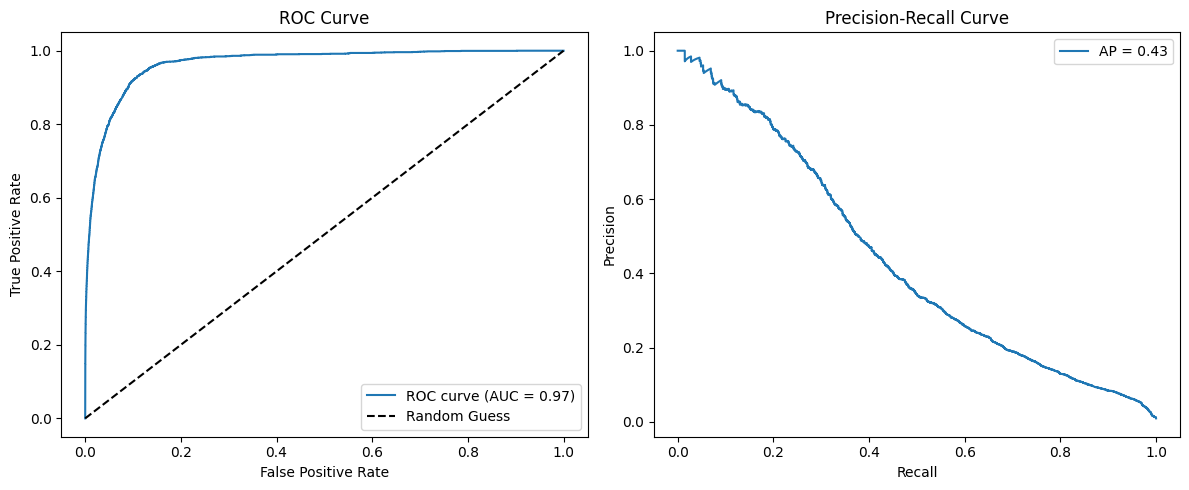

In [128]:
y_pred = baseline_clf.predict_proba(X_train_base)[:, 1]

def make_roc_recall_precision_curves(y_train, y_pred):
    """
    Plot ROC and Precision-Recall curves for binary classification results.

    Args:
        y_train (array-like): True binary labels.
        y_pred (array-like): Predicted probabilities or scores for the positive class.

    Displays:
        - ROC curve with AUC score.
        - Precision-Recall curve with average precision score.
    """
    fpr, tpr, _ = roc_curve(y_train, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_train, y_pred)
    avg_precision = average_precision_score(y_train, y_pred)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

make_roc_recall_precision_curves(y_train, y_pred)

**Hyperparameter Tuning**

Using Optuna, we define an objective function. The sampler automatically picks a value for each of the search spaces, penalty, max_iter and C. The training/validation process is contained within the objective function. We include a Pruner to cut short unpromising trials.

In [129]:
def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0, 30)

    clf = LogisticRegression(
        solver='liblinear',
        penalty=penalty,
        random_state=42,
    )

    clf.fit(X_tr, y_tr)
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_val)[:, 1]
    else:
        y_score = clf.decision_function(X_val)
    score = roc_auc_score(y_val, y_score)

    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return score

pruner = MedianPruner(n_startup_trials=2, n_warmup_steps=0)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-24 11:56:10,295] A new study created in memory with name: no-name-0ddd7981-b0ca-45b2-85c3-3084d45298e0
[I 2025-06-24 11:56:11,297] Trial 0 finished with value: 0.9284694843641811 and parameters: {'penalty': 'l2', 'C': 23.866277450336412}. Best is trial 0 with value: 0.9284694843641811.
[I 2025-06-24 11:56:12,364] Trial 1 finished with value: 0.9284694843641811 and parameters: {'penalty': 'l2', 'C': 26.563319826697736}. Best is trial 0 with value: 0.9284694843641811.
[I 2025-06-24 11:56:13,311] Trial 2 finished with value: 0.9284694843641811 and parameters: {'penalty': 'l2', 'C': 11.195427190099277}. Best is trial 0 with value: 0.9284694843641811.
[I 2025-06-24 11:56:14,317] Trial 3 finished with value: 0.9284694843641811 and parameters: {'penalty': 'l2', 'C': 19.509938531228535}. Best is trial 0 with value: 0.9284694843641811.
[I 2025-06-24 11:56:15,682] Trial 4 finished with value: 0.9284694843641811 and parameters: {'penalty': 'l2', 'C': 13.744648997901022}. Best is trial 

Best trial:
  Value: 0.9284694843641811
  Params: 
    penalty: l2
    C: 23.866277450336412


**Approach 2: LogisticRegressor with engineered features**

Using the hyperparameters obtained, we fit a new model on the full dataset with engineered features.

In [130]:
final_clf = LogisticRegression(**study.best_params, max_iter = 6000)
cv_scores1 = train_and_predict(model=final_clf, X_train = X_train, y_train = y_train, 
                               X_test = X_test, site_feature_names = site_feature_names, new_feature_names= new_feature_names,              
                               cv = time_split, submission_file_name='../data/best_params_logreg_submission.csv')

CV scores [0.78592729 0.82210452 0.77006556 0.96309105 0.93029848 0.97364868
 0.92605462 0.95134747 0.94465081 0.97600423]
CV mean: 0.9043192695994435, CV std: 0.07562078945349351


Weight?,Feature
+18.555,cid-ed6c3e6a5c6608a4.users.storage.live.com
+16.775,www.express.co.uk
+14.779,fr.glee.wikia.com
+14.585,www.banque-chalus.fr
+12.375,www.tete-en-lair.com
+11.378,www.video.tt
+11.133,static.weezbe.com
+11.066,glee.hypnoweb.net
+11.040,tru.am
+10.720,s.radio-canada.ca


New feature weights:
             feature      coef
0            period1  1.754136
1            period2  3.470370
2            period3 -0.736780
3  peak_alice_months -0.300017
4            mon_tue  0.766643
5        wed_sat_sun -2.905953
6   session_duration -0.117973
7        start_month -1.304042
8         start_week  0.621901


Our new features have moderate importances.

Redefine X_tr and X_val to include engineered features.

In [131]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X_train))
train_idx, valid_idx = splits[-1]
X_tr, X_val = X_train[train_idx], X_train[valid_idx]
y_tr, y_val = y_train[train_idx], y_train[valid_idx]

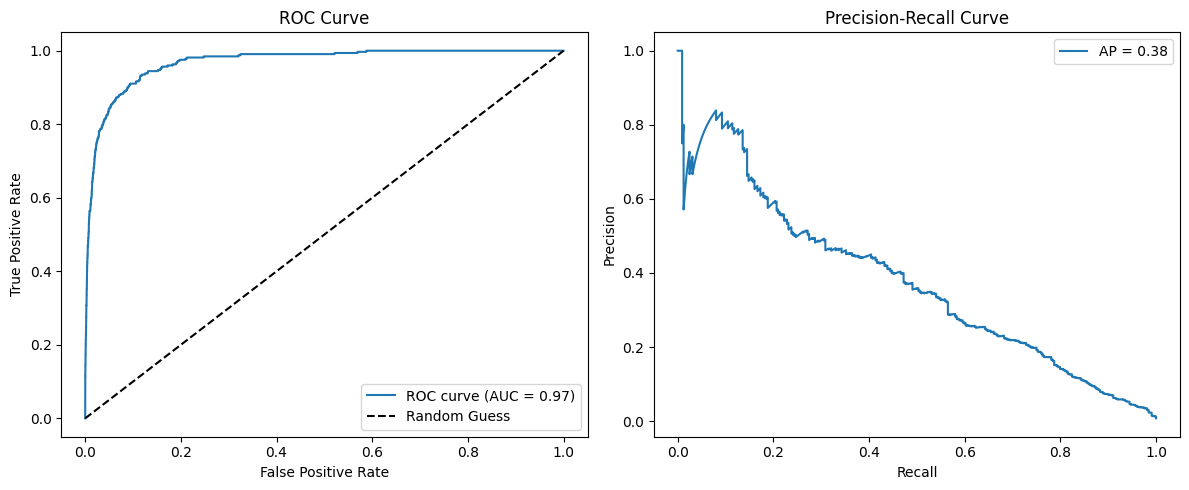

In [132]:
# Predict probabilities on validation set
final_clf.fit(X_tr, y_tr)
y_pred = final_clf.predict_proba(X_val)[:, 1]

make_roc_recall_precision_curves(y_val, y_pred)

The ROC curve mainatains the same level of accuracy. Precision-Recall graph suggests that the model is able to identify the positive class less frequently. As a result, there is a decrease in leaderboard score when introducing time features (From 0.91516 to 0.80317).

**Aproach 3: Oversampling**

Using a RandomOverSampler, which will automatically resamples the minority class, we aim to make the model better at gaining intuition of the minority class.

In [133]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X_train))
train_idx, valid_idx = splits[-1]
X_tr, X_val = X_train[train_idx], X_train[valid_idx]
y_tr, y_val = y_train[train_idx], y_train[valid_idx]

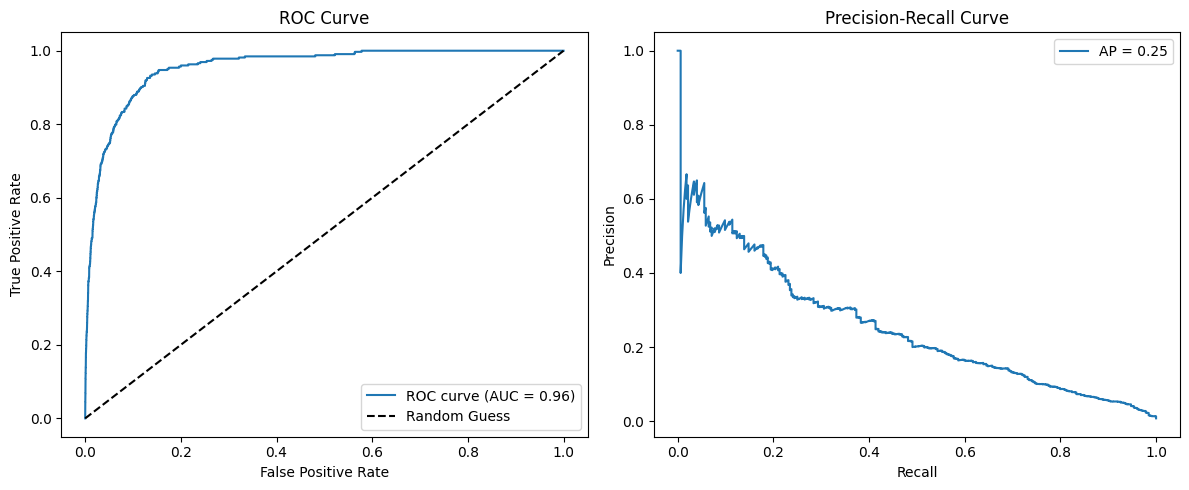

In [134]:
from imblearn.over_sampling import RandomOverSampler

# Oversample the minority class in the baseline feature set
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_tr, y_tr)

# Train a new logistic regression model on the oversampled data
oversampled_clf = LogisticRegression(C = 14.8, max_iter=  10000, penalty = 'l2', solver = 'liblinear')
oversampled_clf.fit(X_train_oversampled, y_train_oversampled)

# Predict on the original training set for visualization
y_pred_oversampled = oversampled_clf.predict_proba(X_val)[:, 1]

# Use the helper function to plot ROC and Precision-Recall curves
make_roc_recall_precision_curves(y_val, y_pred_oversampled)

From the ROC curve, ROC AUC decreased. Precision-Recall graph gives a lower average precision. We don't use this approach.

**Aproach 4: Dividing the intra-day features into smaller periods**

By dividing the hours of a day into smaller subsections where there are high periods of activity of Alice vs. Intruder, we gained a small improvements from the last dataset with engineered features. The leaderboard score is 0.87156 compared to the previous 0.80317. However, this is still lower than the baseline, suggesting that some of the features introduced noise.

**Aproach 5: Removing some features**


We remove some features from the dataset.

In [135]:
all_feature_names = list(site_feature_names) + list(new_feature_names)

# Specify the features you want to remove
features_to_remove = ["period1", "period2", "period3", "peak_alice_months",
    "mon_tue", "wed_sat_sun", "year", "session_duration", "start_month", "start_week"]  # example

# Get indices of features to keep
features_to_keep = [i for i, name in enumerate(all_feature_names) if name not in features_to_remove]

# Select only the columns to keep

X_train_selected = X_train[:, features_to_keep]
X_test_selected = X_test[:, features_to_keep]
selected_feature_names = [all_feature_names[i] for i in features_to_keep]

Redo the training/validation process

In [136]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X_train))
train_idx, valid_idx = splits[-1]
X_tr, X_val = X_train_selected[train_idx], X_train_selected[valid_idx]
y_tr, y_val = y_train[train_idx], y_train[valid_idx]

In [137]:
final_clf = LogisticRegression()
final_clf.fit(X_tr, y_tr)
y_pred = final_clf.predict_proba(X_val)[:, 1]

In [138]:
cv_scores1 = train_and_predict(model=final_clf, X_train = X_train_selected, y_train = y_train, 
                               X_test = X_test_selected, site_feature_names = selected_feature_names,              
                               cv = time_split, submission_file_name='../data/feature_selection_logreg_submission.csv')

CV scores [0.83587387 0.65248713 0.85734389 0.93515262 0.84108439 0.88801055
 0.90831387 0.86861264 0.91777072 0.91411213]
CV mean: 0.8618761805430456, CV std: 0.07686339183814671


Weight?,Feature
+6.935,youwatch.org
+5.904,fr.glee.wikia.com
+4.816,vk.com
+4.584,www.info-jeunes.net
+4.531,www.banque-chalus.fr
+4.301,www.audienceinsights.net
+4.133,www.melty.fr
+4.112,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.999,api.bing.com
+3.992,media-1.melty.fr


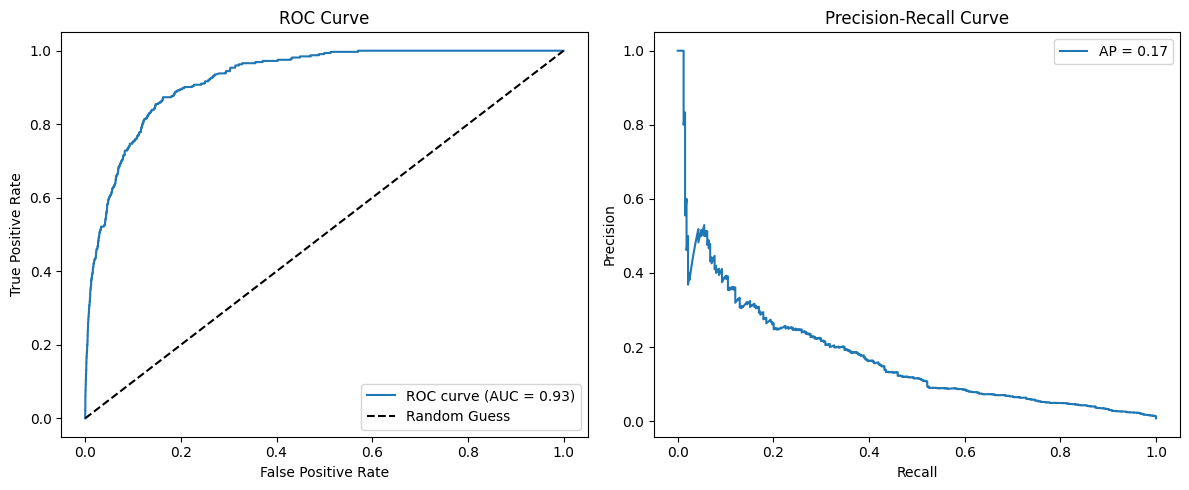

In [139]:
# Use the helper function to plot ROC and Precision-Recall curves
make_roc_recall_precision_curves(y_val, y_pred)

Removing features still resulted in worse results.